In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








# beta_rel = 0.305
beta_rel = 0.106

# gamma = 1.050
gamma = 1.006


I=0.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for LEIR
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T





beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )




num_particles=int(1e4)

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,1e-40 ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=np.random.normal(0, 1e-40, num_particles),
        py=np.random.normal(0, 1e-40, num_particles),
        delta=np.random.normal(0, 1e-40, num_particles),
        zeta=np.random.normal(0, 1e-40, num_particles))

dtk_particle_copy_old=dtk_particle.copy()






In [2]:
#xp_cooler=1e-3

B_ratio=1e-3


cooler = dtk.elements.ElectronCooler(current=I, length=L, r_beam=r_beam,
                                        T_perp=T_perp, T_l=T_l,
                                        magnetic_field=B,B_ratio=B_ratio,
                                        Neutralisation_space_charge=0,
                                        offset_px=0)

cooler_0 = dtk.elements.ElectronCooler(current=I, length=L, r_beam=r_beam,
                                        T_perp=T_perp, T_l=T_l,
                                        magnetic_field=B,B_ratio=0,
                                        Neutralisation_space_charge=0,
                                        offset_px=0)


coolers = []
num_coolers=int(1e4)


for i in range(num_coolers):
    angle=np.random.normal(0,B_ratio,1)
    #angle=np.random.uniform(-B_ratio,B_ratio,1)
    #print('angle:',angle)
    cooler_tiny = dtk.elements.ElectronCooler(current=I, length=L, r_beam=r_beam,
                                         T_perp=T_perp, T_l=T_l,
                                         magnetic_field=B,B_ratio=0,
                                         Neutralisation_space_charge=0,
                                         offset_px=angle)
    coolers.append(cooler_tiny)



In [3]:
num_turns=int(1)



x=[]
px=[]
action = []
force = []
force_old = []
force_0 = []


for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    
    action_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
    action.append(action_temp)
    
   
    force_temp=[]        
    Fx,Fy,Fl=cooler.force(dtk_particle)
    force_old.append(Fx)

    force_x0,force_y0,force_l0=cooler_0.force(dtk_particle_copy_old)
    force_0.append(force_x0)

    for cooler_small in coolers:
        f1,f2,f3=cooler_small.force(dtk_particle)
        force_temp.append(f1)
        
        
    force_temp=np.array(force_temp)
    force=force_temp.mean(axis=0)  
    #force=np.squeeze(force)


x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force)
force_old = np.array(force_old)
force_0 = np.array(force_0)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [18:18<00:00, 1098.49s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


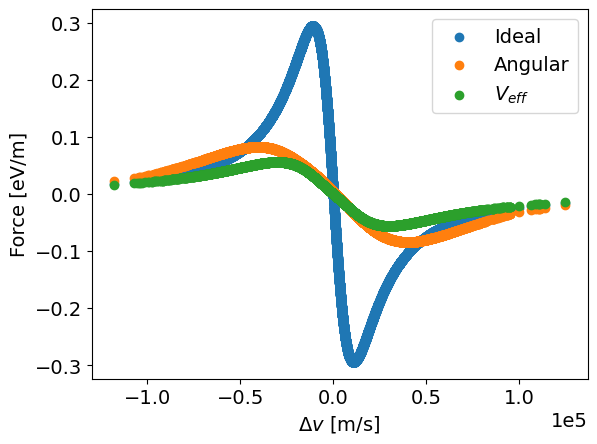

In [4]:
import numpy as np
import matplotlib.pyplot as plt

px_tot = p0c * px
beta_diff = px_tot / (mass0 * gamma)
v_diff = beta_diff * c

# Set the font size
plt.rcParams.update({'font.size': 14})

# Create the scatter plot
plt.scatter(v_diff, force_0, label='Ideal')
plt.scatter(v_diff, force, label='Angular')
plt.scatter(v_diff, force_old, label='$V_{eff}$')

# Set the plot properties
plt.xlabel('$\Delta v$ [m/s]')
plt.ylabel('Force [eV/m]')
plt.legend()

# Set x-axis tick labels to scientific notation
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))

# Save the plot to a file
plt.savefig('angle_imperfection_force.png', dpi=300)
plt.savefig('angle_imperfection_force.eps', dpi=300)

# Show the plot
plt.show()


In [5]:
# plt.scatter(px,force_0)